In [2311]:
import pandas as pd
import matplotlib.pyplot as plt
from tdmsdata import TdmsData
import numpy as np
from scipy.optimize import curve_fit
from statistics import mean
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde
import doppler_shift
import importlib
from scipy import stats

In [2312]:
# inputs
file = '20231124_0955_Sn_118_res_scan.tdms'
channel = 1
isotope = 118

In [2313]:
# Function to read TDMS file and extract raw data
def read_tdms(file, channel):
    TDMS = TdmsData(''.join(['/Users/xnimir/Desktop/Sn exp/Week47_17-11-2023/Isotope shift/{}'.format(file)]))
    raw_data = TDMS.get_raw_data(''.join(['Channel ', str(channel)]))  # 2D np array
    return raw_data

In [2314]:
# Function to create a dataset from raw data
def create_dataset(raw_data):
    return pd.DataFrame({'Cycle': raw_data[:, 0], 'Time(sec)': raw_data[:, 1], 'Wavelength (nm)': raw_data[:, 2]})

In [2315]:
# Function to filter the data for Sn-122 because magnet was changed too early 
def filter_data_for_sn122(dataset):
    newcycle = dataset[dataset['Cycle'].between(0, 1)]
    wavelengths_new = newcycle['Wavelength (nm)']
    sep_time_sn122 = newcycle["Time(sec)"]
    return wavelengths_new, sep_time_sn122

In [2316]:
def doppler_shift_calc(dataset):
    importlib.reload(doppler_shift)

    # Copying the original dataframe to avoid modifying it directly
    doppler_df = dataset.copy()

    # Get the original wavelengths from the dataframe 
    wavelengths = doppler_df['Wavelength (nm)']

    # Apply the Doppler shift to the wavelengths
    shifted_wls = doppler_shift.getshift(wavelengths, isotope)

    # Add the shifted wavelengths as a new column to the copied dataframe
    doppler_df['Shifted Wavelength'] = shifted_wls

    return doppler_df

In [2317]:
def get_bin_range(wavelengths, num_bins, width=0.07):
    clean_wavelengths = wavelengths[np.isfinite(wavelengths)]

    # Define the range to exclude
    exclude_start = 0.05

    # Define the updated range excluding the first 0.01 nm
    min_wavelength = np.min(clean_wavelengths)
    max_wavelength = np.max(clean_wavelengths)
    adjusted_min_wavelength = min_wavelength + exclude_start
    
    # Ensure that adjusted_min_wavelength is within the bounds of your data
    if adjusted_min_wavelength > max_wavelength:
        adjusted_min_wavelength = max_wavelength
    
    # Update the range based on the new minimum wavelength
    counts, bin_edges = np.histogram(clean_wavelengths, bins=num_bins, range=(adjusted_min_wavelength, max_wavelength))
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    # Find the peak wavelength in the filtered data
    peak_index = np.argmax(counts)
    peak_wavelength = bin_centers[peak_index]

    half_width = width / 2
    bin_range = (peak_wavelength - half_width, peak_wavelength + half_width)
    
    # print(f"Peak Wavelength: {peak_wavelength}")
    # print(f"Bin Range: {bin_range}")
    
    return bin_range

In [2318]:
# Function to plot the histogram 
def plot_histogram(wavelengths, num_bins, bins_range):

    fig, wl_hist = plt.subplots(1, 1)
    
    # Plot histogram
    counts, bins, _ = wl_hist.hist(
        wavelengths,
        bins=num_bins,
        range=bins_range,
        log=False,
        histtype='step',
        # alpha=0.5 # changes opacity of graph
    )

    # Calculate bin centers
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # # Find non-zero bins (i.e., those contributing to the outer shape)
    # non_zero_idx = np.where(counts > 0)[0]
    # outer_bin_centers = bin_centers[non_zero_idx]
    # outer_counts = counts[non_zero_idx]

    # # Smooth using cubic spline interpolation on the outer bins only
    # interp_func = interp1d(outer_bin_centers, outer_counts, kind='cubic')
    # smooth_bin_centers = np.linspace(outer_bin_centers.min(), outer_bin_centers.max(), 5000)
    # smooth_counts = interp_func(smooth_bin_centers)

    # # # Plot 
    # wl_hist.plot(smooth_bin_centers, smooth_counts)

    # plt.xlabel('Wavelength (nm)')
    # plt.ylabel('Counts')

    wl_hist.set_title(f'{file}, bins = {num_bins}')
    wl_hist.set_xlabel('Wavelength (nm)')
    wl_hist.set_ylabel('Counts')

    plt.show()


    return counts, bins, bin_centers

In [2319]:
# Function to plot only KDE curve
def plot_kde(wavelengths, bins_range, bins=500):
    clean_wavelengths = wavelengths[np.isfinite(wavelengths)]  # Remove inf and NaN values

    fig, ax = plt.subplots(1, 1)
    
    # Perform Gaussian KDE to get a smooth estimate of the distribution
    kde = gaussian_kde(clean_wavelengths, bw_method=0.1)

    # Generate a smooth bin center range
    smooth_bin_centers = np.linspace(bins_range[0], bins_range[1], 1000)

    # Compute KDE values, and scale by bin width and total number of points
    bin_width = (bins_range[1] - bins_range[0]) / bins
    smooth_counts = kde(smooth_bin_centers) * len(clean_wavelengths) * bin_width  # Scale KDE by the total number of points and bin width

    # Plot 
    ax.plot(smooth_bin_centers, smooth_counts, label='KDE')
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('Counts')
    ax.set_title(f'{file}, bins = {bins}')
    ax.legend()
    plt.show()

    return smooth_counts, smooth_bin_centers

In [2320]:
def plot_scatter(counts, bins):
    # Calculate bin centers
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    
    # Find non-zero bins (i.e., those contributing to the outer shape)
    non_zero_idx = np.where(counts > 0)[0]
    outer_bin_centers = bin_centers[non_zero_idx]
    outer_counts = counts[non_zero_idx]

    stat_error = np.sqrt(outer_counts)
    
    # Scatter plot
    fig, ax = plt.subplots(1, 1)
    ax.errorbar(outer_bin_centers, outer_counts, yerr=stat_error, fmt='o', capsize=2, elinewidth=1, markersize=5)
   
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('Counts')
    ax.set_title(f'{file}')
    # ax.set_xlim(1534.19, 1534.25)
    plt.show()


    return outer_counts, outer_bin_centers

In [2321]:
def gaussian(x, A, mu, sigma):
    return A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

In [2322]:
def gaussian_exponential(x, A1, mu1, sigma1, B, tau, transition_point, width):
    gaussian_part = gaussian(x, A1, mu1, sigma1)
    exponential = B * np.exp(-x / tau)

    # transition = np.heaviside(x - transition_point, 0)
    transition = 1 / (1 + np.exp(-(x - transition_point) / width))
    
    return gaussian_part * (1 - transition) + exponential * transition

In [2323]:
def fit_and_plot(counts, bin_centers):
    peak_index = np.argmax(counts)
    peak_wavelength = bin_centers[peak_index]

    # Initial guesses for each model
    initial_guess_gaussian = [np.max(counts), np.mean(bin_centers), np.std(bin_centers)]
    initial_guess_combined = [np.max(counts), np.mean(bin_centers), np.std(bin_centers), np.max(counts), 10, peak_wavelength, 0.1]
    
    # Fit Gaussian model
    popt_gaussian, _ = curve_fit(gaussian, bin_centers, counts, p0=initial_guess_gaussian)
        
    # Fit Combined model
    popt_combined, _ = curve_fit(gaussian_exponential, bin_centers, counts, p0=initial_guess_combined)
    
    # Generate x values for the fit curves
    x_fit = np.linspace(bin_centers.min(), bin_centers.max(), 1000)
    
    # Generate fitted curves
    y_fit_gaussian = gaussian(x_fit, *popt_gaussian)
    y_fit_combined = gaussian_exponential(x_fit, *popt_combined)
    
    # Plot the data and fits
    fig, ax = plt.subplots()
    ax.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt='o', capsize=2, elinewidth=1, markersize=5)
    ax.plot(x_fit, y_fit_gaussian, 'r-', label='Gaussian Fit')
    ax.plot(x_fit, y_fit_combined, 'b-', label='Gaussian + Exponential Fit')
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('Counts')
    ax.set_title('Fits')
    ax.legend()
    plt.show()

    # Calc 
    # print(popt_combined)

    
    return popt_gaussian, popt_combined


In [2324]:
def calculate_peak_and_fwhm(counts, bin_centers):
    # Find peak wavelength
    peak_index = np.argmax(counts)
    peak_wavelength = bin_centers[peak_index]
    
    # Calculate half maximum
    max_count = np.max(counts)
    half_max = max_count / 2

    # Interpolation function to find the exact crossing points
    def find_crossing(bin_centers, counts, threshold):
        for i in range(1, len(counts)):
            if counts[i-1] < threshold <= counts[i]:
                # Linear interpolation to find the exact crossing point by calculating first slope and intercept in a given range, then threshold = mx+b to solve for exact crossing point 
                slope = (counts[i] - counts[i-1]) / (bin_centers[i] - bin_centers[i-1])
                intercept = counts[i-1] - slope * bin_centers[i-1]
                crossing_wavelength = (threshold - intercept) / slope
                return crossing_wavelength
        return None

    # Find the crossing points for half_max
    left_wavelength = find_crossing(bin_centers, counts, half_max)
    right_wavelength = find_crossing(bin_centers[::-1], counts[::-1], half_max)

    fwhm = right_wavelength - left_wavelength
    
    return fwhm, peak_wavelength

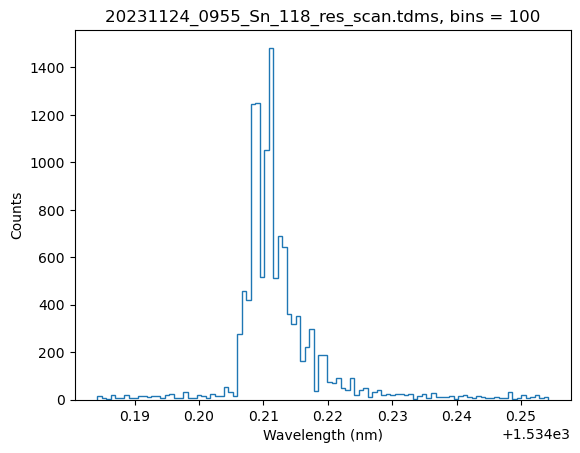

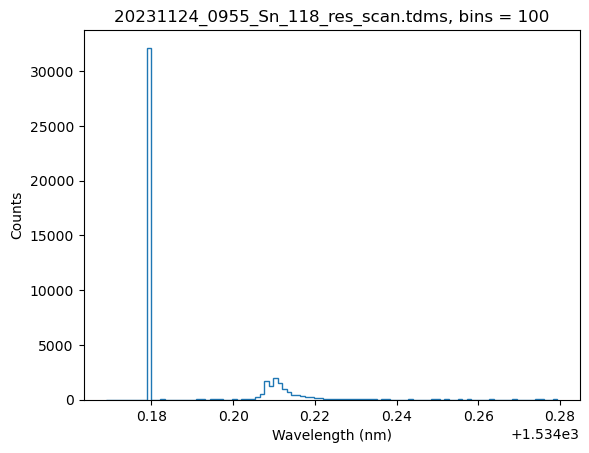

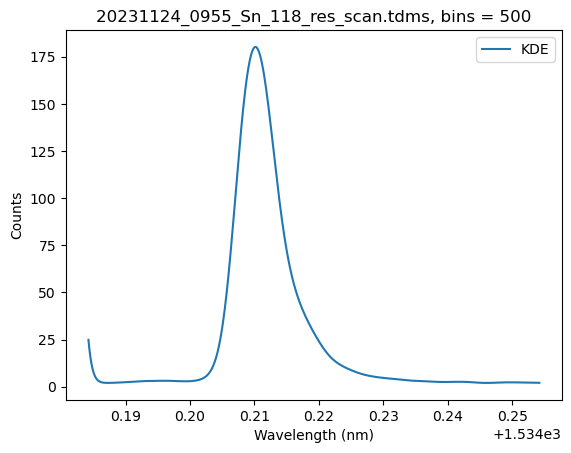

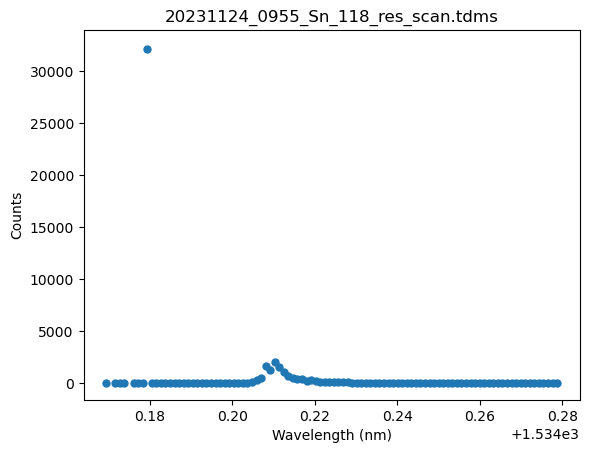

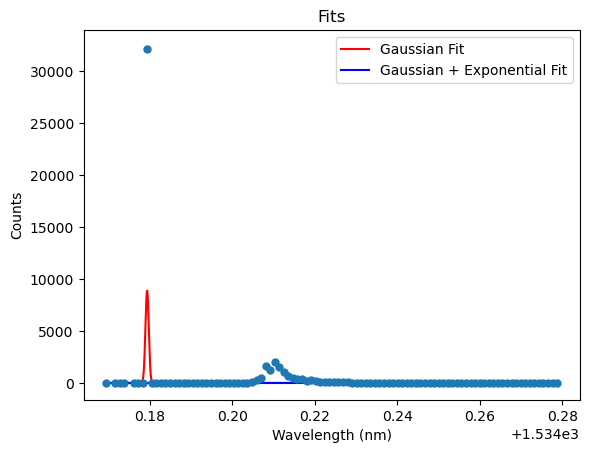

Histogram
Peak Wavelength: 1534.1794061052444 nm
FWHM: 0.0011041950929211453 nm

KDE
Peak Wavelength: 1534.210147986694 nm
FWHM: 0.007428863656741669 nm

Scatter
Peak Wavelength: 1534.1794061052444 nm
FWHM: 0.0011041950929211453 nm

Gaussian
Peak Wavelength: 1534.1793862428879 nm
FWHM: 0.0009446380286197935 nm

Gaussian + Exponential
Peak Wavelength: 1533.8511095630065 nm
Histogram
Peak Wavelength: 1534.1794061052444 nm
FWHM: 0.0011041950929211453 nm

KDE
Peak Wavelength: 1534.210147986694 nm
FWHM: 0.007428863656741669 nm

Scatter
Peak Wavelength: 1534.1794061052444 nm
FWHM: 0.0011041950929211453 nm

Gaussian
Peak Wavelength: 1534.1793862428879 nm
FWHM: 0.0009446380286197935 nm

Gaussian + Exponential
Peak Wavelength: 1533.8511095630065 nm

Doppler corrected


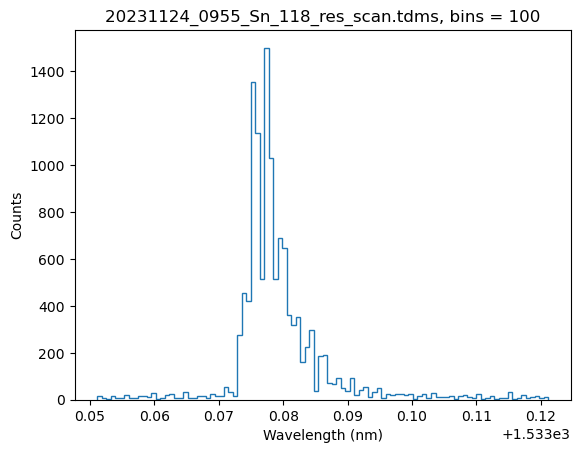

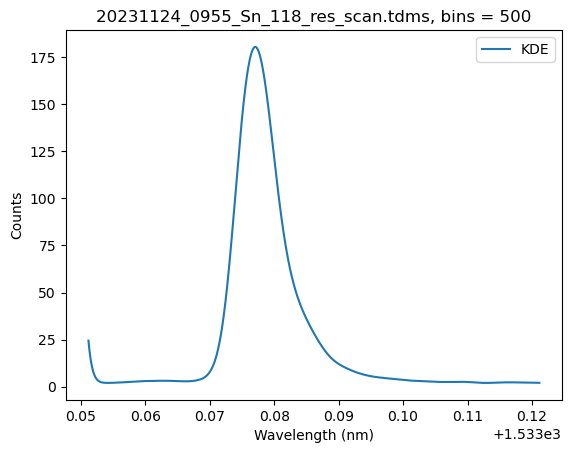

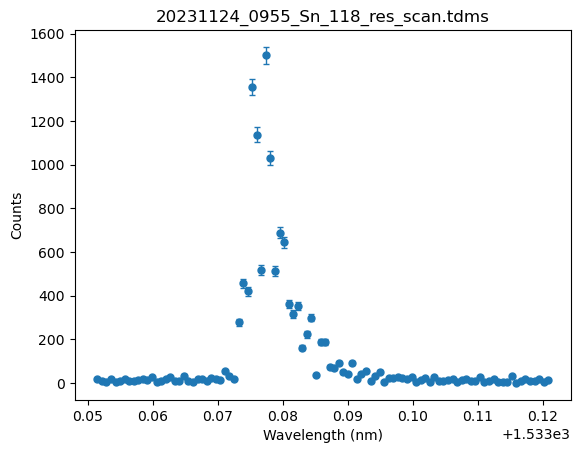

/usr/local/Caskroom/miniforge/base/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


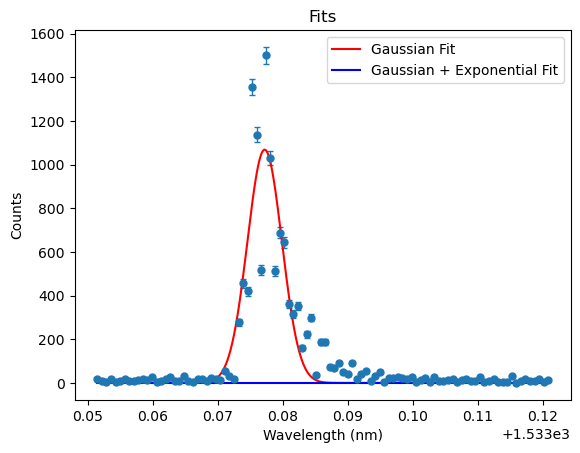

Histogram
Peak Wavelength: 1533.0773996734333 nm
FWHM: 0.0036332366018996254 nm

KDE
Peak Wavelength: 1533.0770755993592 nm
FWHM: 0.00742365979317583 nm

Scatter
Peak Wavelength: 1533.0773996734333 nm
FWHM: 0.0036332366018996254 nm

Gaussian
Peak Wavelength: 1533.0772183153094 nm
FWHM: 0.006241874349941568 nm

Gaussian + Exponential
Peak Wavelength: 1544.1221431628073 nm


In [2325]:
# Main function to run the entire analysis
def analyze_wavelength(file, channel):
    # Read raw data
    raw_data = read_tdms(file, channel)
    
    # Convert raw data to a dataset
    dataset = create_dataset(raw_data)
    
    # Plots and fits uncorrected
    wavelengths = dataset['Wavelength (nm)']
    num_bins = 100
    bins_range = get_bin_range(wavelengths, num_bins)
    # bins_range=(1534.19, 1534.29)
    counts_hist, bins_hist, bin_centers_hist = plot_histogram(wavelengths, num_bins, bins_range)
    counts_hist, bins_hist, bin_centers_hist = plot_histogram(wavelengths, num_bins, None)
    counts_kde, bin_centers_kde = plot_kde(wavelengths, bins_range)
    counts_scatter, bin_centers_scatter = plot_scatter(counts_hist, bins_hist)
    popt_gaussian, popt_combined = fit_and_plot(counts_scatter, bin_centers_scatter)

    # Calculate the FWHM and WL peak uncorrected
    fwhm_hist, peak_hist = calculate_peak_and_fwhm(counts_hist, bin_centers_hist)
    fwhm_kde, peak_kde = calculate_peak_and_fwhm(counts_kde, bin_centers_kde)
    fwhm_scatter, peak_scatter = calculate_peak_and_fwhm(counts_scatter, bin_centers_scatter)
    fwhm_gaussian = 2 * np.sqrt(2 * np.log(2)) * popt_gaussian[2]

    # Print the results
    print("Histogram")
    print(f"Peak Wavelength: {peak_hist} nm")
    print(f"FWHM: {fwhm_hist} nm")
    
    print("\nKDE")
    print(f"Peak Wavelength: {peak_kde} nm")
    print(f"FWHM: {fwhm_kde} nm")

    print("\nScatter")
    print(f"Peak Wavelength: {peak_scatter} nm")
    print(f"FWHM: {fwhm_scatter} nm")

    print("\nGaussian")
    print(f"Peak Wavelength: {popt_gaussian[1]} nm")
    print(f"FWHM: {fwhm_gaussian} nm")

    print("\nGaussian + Exponential")
    print(f"Peak Wavelength: {popt_combined[1]} nm")

    # Print the results
    print("Histogram")
    print(f"Peak Wavelength: {peak_hist} nm")
    print(f"FWHM: {fwhm_hist} nm")
    
    print("\nKDE")
    print(f"Peak Wavelength: {peak_kde} nm")
    print(f"FWHM: {fwhm_kde} nm")

    print("\nScatter")
    print(f"Peak Wavelength: {peak_scatter} nm")
    print(f"FWHM: {fwhm_scatter} nm")

    print("\nGaussian")
    print(f"Peak Wavelength: {popt_gaussian[1]} nm")
    print(f"FWHM: {fwhm_gaussian} nm")

    print("\nGaussian + Exponential")
    print(f"Peak Wavelength: {popt_combined[1]} nm")

    # Doppler correction
    print("\nDoppler corrected")

    doppler_df = doppler_shift_calc(dataset) # data frame with doppler shifted wls 
    doppler_wavelengths = doppler_df['Shifted Wavelength']
    bins_range = get_bin_range(doppler_wavelengths, num_bins)
    # bins_range=(1533.06, 1533.12)
    counts_hist_cor, bins_hist_cor, bin_centers_hist_cor = plot_histogram(doppler_wavelengths, num_bins, bins_range)
    counts_kde_cor, bin_centers_kde_cor = plot_kde(doppler_wavelengths, bins_range)
    counts_scatter_cor, bin_centers_scatter_cor = plot_scatter(counts_hist_cor, bins_hist_cor)
    popt_gaussian_cor, popt_combined_cor = fit_and_plot(counts_scatter_cor, bin_centers_scatter_cor)
    
    fwhm_hist_cor, peak_hist_cor = calculate_peak_and_fwhm(counts_hist_cor, bin_centers_hist_cor)
    fwhm_kde_cor, peak_kde_cor = calculate_peak_and_fwhm(counts_kde_cor, bin_centers_kde_cor)
    fwhm_scatter_cor, peak_scatter_cor = calculate_peak_and_fwhm(counts_scatter_cor, bin_centers_scatter_cor)
    fwhm_gaussian_cor = 2 * np.sqrt(2 * np.log(2)) * popt_gaussian_cor[2]

    print("Histogram")
    print(f"Peak Wavelength: {peak_hist_cor} nm")
    print(f"FWHM: {fwhm_hist_cor} nm")
    
    print("\nKDE")
    print(f"Peak Wavelength: {peak_kde_cor} nm")
    print(f"FWHM: {fwhm_kde_cor} nm")

    print("\nScatter")
    print(f"Peak Wavelength: {peak_scatter_cor} nm")
    print(f"FWHM: {fwhm_scatter_cor} nm")

    print("\nGaussian")
    print(f"Peak Wavelength: {popt_gaussian_cor[1]} nm")
    print(f"FWHM: {fwhm_gaussian_cor} nm")

    print("\nGaussian + Exponential")
    print(f"Peak Wavelength: {popt_combined_cor[1]} nm")

    


analyze_wavelength(file, channel)
